<a href="https://colab.research.google.com/github/yusnivtr/pytorch-deep-learning/blob/main/my_notebook/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
torch.__version__

'2.5.1+cu124'

# Data (Prepare and loading)

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

Splitting data into training and test

In [4]:
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_label=y_train,
                     test_data = X_test,
                     test_label=y_test,
                     predictions = None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data,train_label,c='b',s=4,label="Traning Data")

  plt.scatter(test_data,test_label,c='g',s=4,label="Test Data")

  if predictions is not None:
    plt.scatter(test_data,predictions,c='r',s=4,label='Predictions')

  plt.legend(prop={"size":14})

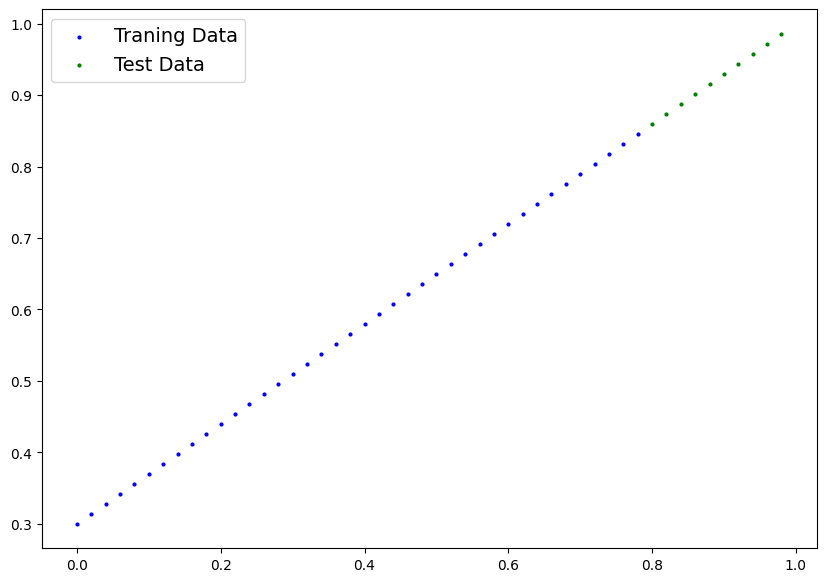

In [6]:
plot_predictions();

# Build model

In [7]:
from torch import nn
# Create linear Regression Model
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.rand(1,
                                        requires_grad=True,
                                        dtype=torch.float))

    # Forward method to define the computation in the model
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.weights*x+self.bias


### PyTorch model bulidings esentials

* torch.nn - contains all of the buildings for computational graphs ( a neural network can be considered as a computational graph)
* torch.nn.Parameter - what parameter should our model try and learn, often a layer from torch.nn will set these for us
* torch.nn.Module -  the base class for all neural network modules, it subclass it, should overwrite forward method.
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite this, this method defines what happens in the forward computation.

PyTorch cheat sheet : https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch Model

So we can check our model parameters or what's inside our model using `.parameter()`

In [8]:
# Create random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

In [10]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

When we pass data through our model, it's going to run it through the forward() method


In [11]:
# Make predictions with model
# with torch.inference_mode():
#   y_preds = model_0(X_test)
# Also do something similar with torch.no_grad()
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

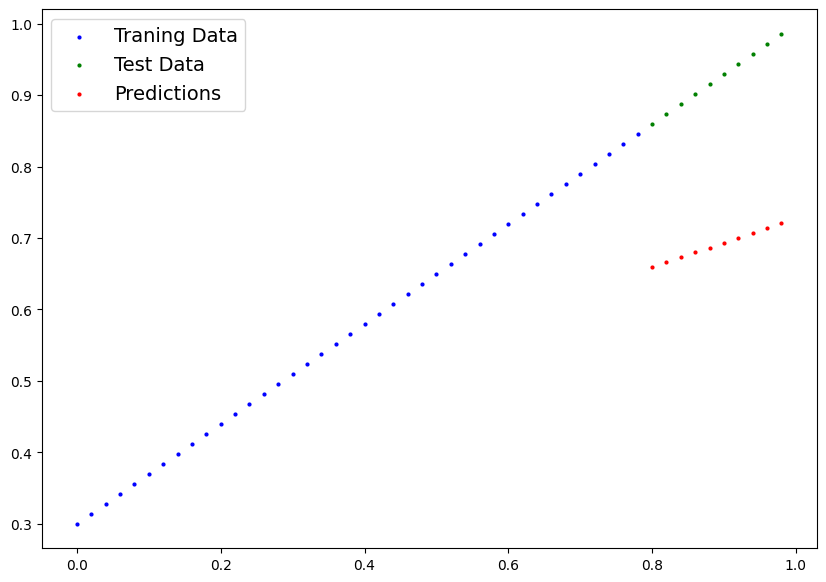

In [13]:
plot_predictions(predictions=y_preds)

# Train model
The whole idea of traning is for a model to move from some unknown params to ideal params

One way to measure how poor of predictions is to use loss function

Things we need to train:
* Loss function
* Optimizer: Take into account the loss of a model and adjusts the model's parameters.
  * Inside the optimizer:
    * `params` - the model parameters you'd like to optimizer
    * `lr` (learning rate) - the learning rate is hyperparameter that defines ...

And specicallyt for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr = learning rate

### Building a traning loop (and a testing loop)

A couplt things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make prediction on data - also called forward propagation
2. Calculate the loss
3. Optimizer zero grad
4. Look backward - move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust parameters and try to improve the loss. (**gradient descent**)

In [15]:
# An epoch is one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 100
# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to traning mode
  model_0.train() # training mode in PyTorch sets all require gradients is True
  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred,y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()
  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so we have to zero them above in step 3

  ### Testing
  model_0.eval() # turn off different settings in the model not needed for evaluation/testing (dropout/batch norm layer)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_predctions = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_predctions,y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.08169572055339813 | Test loss: 0.22662055492401123
OrderedDict([('weights', tensor([0.3398])), ('bias', tensor([0.3939]))])
Epoch: 10 | Loss: 0.06808149069547653 | Test loss: 0.1807345449924469
OrderedDict([('weights', tensor([0.3672])), ('bias', tensor([0.4154]))])
Epoch: 20 | Loss: 0.06258393079042435 | Test loss: 0.15627031028270721
OrderedDict([('weights', tensor([0.3891])), ('bias', tensor([0.4204]))])
Epoch: 30 | Loss: 0.05879194289445877 | Test loss: 0.1418602615594864
OrderedDict([('weights', tensor([0.4081])), ('bias', tensor([0.4179]))])
Epoch: 40 | Loss: 0.05530194193124771 | Test loss: 0.13084018230438232
OrderedDict([('weights', tensor([0.4261])), ('bias', tensor([0.4129]))])
Epoch: 50 | Loss: 0.051822252571582794 | Test loss: 0.12050700187683105
OrderedDict([('weights', tensor([0.4439])), ('bias', tensor([0.4074]))])
Epoch: 60 | Loss: 0.04838593676686287 | Test loss: 0.11223447322845459
OrderedDict([('weights', tensor([0.4610])), ('bias', tensor([0.4004

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5277])), ('bias', tensor([0.3724]))])

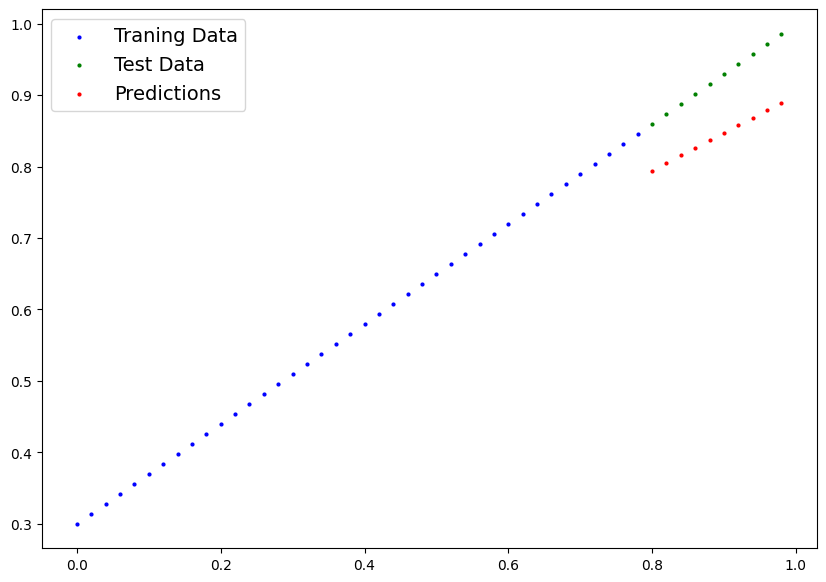

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

Text(0.5, 1.0, 'Traning and Test loss curve ')

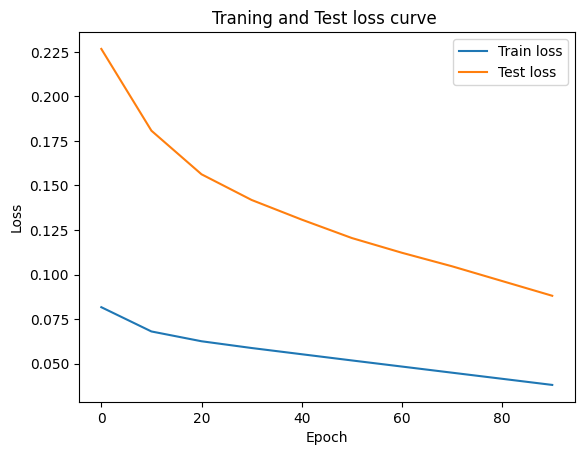

In [18]:
# Plot the loss curves
plt.plot(epoch_count,loss_values,label="Train loss")
plt.plot(epoch_count,test_loss_values,label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Traning and Test loss curve ")

In [19]:
loss_values

[array(0.08169572, dtype=float32),
 array(0.06808149, dtype=float32),
 array(0.06258393, dtype=float32),
 array(0.05879194, dtype=float32),
 array(0.05530194, dtype=float32),
 array(0.05182225, dtype=float32),
 array(0.04838594, dtype=float32),
 array(0.04494876, dtype=float32),
 array(0.04152032, dtype=float32),
 array(0.03808232, dtype=float32)]

# Saving model in PyTorch
There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [20]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model dicrectory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


In [21]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Feb 15 03:01 01_pytorch_workflow_model_0.pth


In [22]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5277])), ('bias', tensor([0.3724]))])

# Loading a PyTorch model

Since we saved our model `state_dict()` rather the entire model, we'll create a new instance of our model class and load the state_dict() into that

In [23]:
# To load in a saved state_dict() we have instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the state dict of model_0 (this will update a new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH,weights_only=True))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5277])), ('bias', tensor([0.3724]))])

In [24]:
# Make some predictions
loaded_model_0.eval()
with torch.inference_mode():
  preds = loaded_model_0(X_test)

y_preds_new == preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together



In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [27]:
weight = 0.7
bias = 0.3

X = torch.arange(0,1,step=0.02).unsqueeze(dim=1)
y = weight*X+bias

In [28]:
train_split = int(len(X)*0.8)
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

In [29]:
torch.manual_seed(42)

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,out_features=1)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

model = LinearRegressionModelV2()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [30]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [31]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model.parameters(),lr=0.001)


In [32]:
epochs = 500

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model.train()
  preds = model(X_train)
  loss = loss_fn(preds,y_train)
  model.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_preds = model(X_test)
    test_loss = loss_fn(test_preds,y_test)
  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Loss : {loss} | Test loss : {test_loss}")


Epoch : 0 | Loss : 0.5551779866218567 | Test loss : 0.5861001014709473
Epoch : 10 | Loss : 0.5436570644378662 | Test loss : 0.5726293921470642
Epoch : 20 | Loss : 0.5321362614631653 | Test loss : 0.5591585040092468
Epoch : 30 | Loss : 0.5206153988838196 | Test loss : 0.5456876754760742
Epoch : 40 | Loss : 0.5090945363044739 | Test loss : 0.5322169661521912
Epoch : 50 | Loss : 0.49757376313209534 | Test loss : 0.5187460780143738
Epoch : 60 | Loss : 0.48605284094810486 | Test loss : 0.5052752494812012
Epoch : 70 | Loss : 0.47453203797340393 | Test loss : 0.49180442094802856
Epoch : 80 | Loss : 0.4630111753940582 | Test loss : 0.4783336818218231
Epoch : 90 | Loss : 0.4514903724193573 | Test loss : 0.4648628234863281
Epoch : 100 | Loss : 0.4399694502353668 | Test loss : 0.4513919949531555
Epoch : 110 | Loss : 0.4284486472606659 | Test loss : 0.4379211962223053
Epoch : 120 | Loss : 0.4169278144836426 | Test loss : 0.4244503974914551
Epoch : 130 | Loss : 0.4054069519042969 | Test loss : 0.41

In [33]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5872]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3560], device='cuda:0'))])

In [34]:
model.eval()
with torch.inference_mode():
  preds = model(X_test)

preds

tensor([[0.8258],
        [0.8375],
        [0.8492],
        [0.8610],
        [0.8727],
        [0.8845],
        [0.8962],
        [0.9080],
        [0.9197],
        [0.9315]], device='cuda:0')

In [35]:
preds = preds.cpu()

In [36]:
preds.device

device(type='cpu')

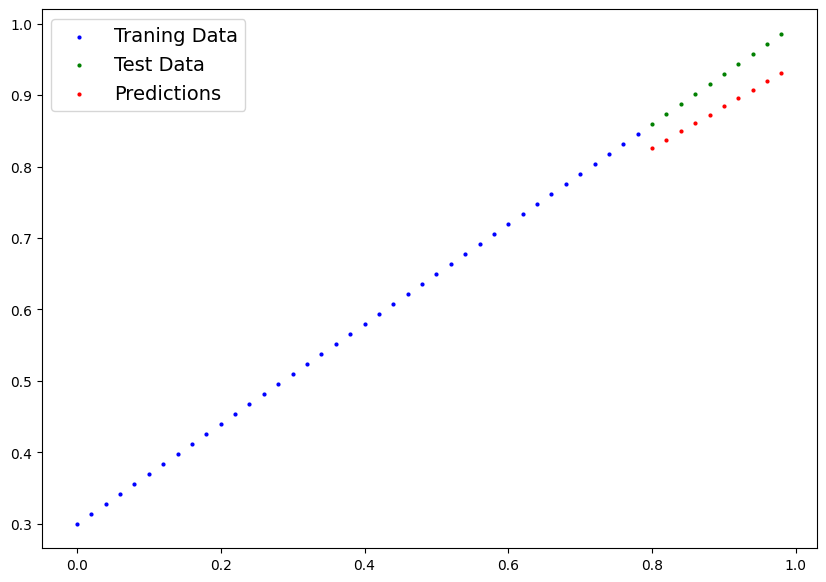

In [37]:
plot_predictions(predictions=preds)

In [41]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_v2.pth"
SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {SAVE_PATH}")
torch.save(obj=model.state_dict(),f=SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_v2.pth


In [46]:
another_model = LinearRegressionModelV2().to(device)
another_model.load_state_dict(torch.load(f=SAVE_PATH,weights_only=True))

another_model.state_dict()


OrderedDict([('linear_layer.weight', tensor([[0.5872]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3560], device='cuda:0'))])

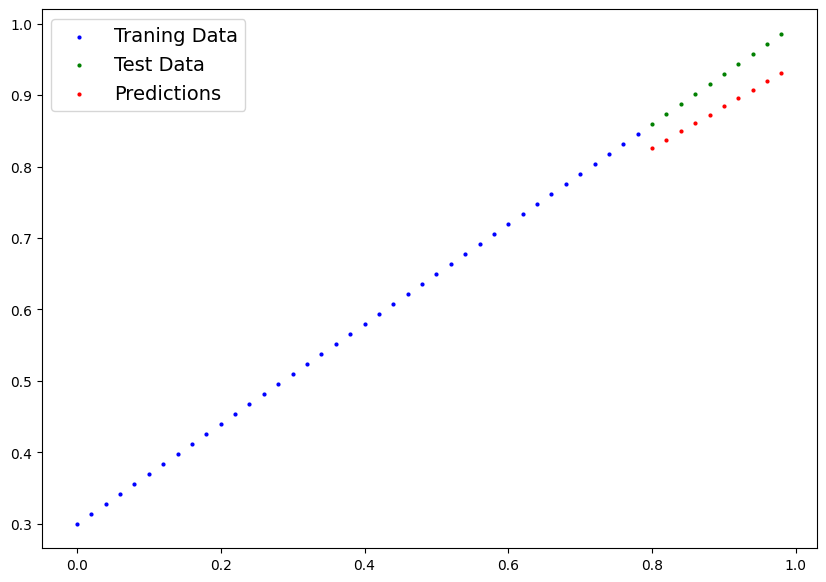

In [48]:
another_model.eval()

with torch.inference_mode():
  preds = another_model(X_test).cpu()
  plot_predictions(predictions=preds)